In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from xgboost import XGBRFRegressor, XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error


In [3]:
df = pd.read_json('json_archive/model_5_df.json')
df['Date/Time (PST)'] = pd.to_datetime(df['Date/Time (PST)'])

In [4]:
df.head()

,Date/Time (PST),Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),...,month,max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow
0,2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.500,259.8,2015-12-04,2.499,25.66,...,12,30.29,20.94,32.02,13.81,21.50,21.50,46.490,46.49,46.49
1,2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.390,278.7,2015-12-04,2.701,23.25,...,12,30.29,21.20,32.02,15.03,21.50,21.50,46.490,46.49,46.49
10,2015-12-04 10:00:00,12.74,29.41,0.000,2.261,7.299,261.7,2015-12-04,1.083,26.44,...,12,30.29,23.39,30.29,17.25,21.50,21.50,2.701,46.49,46.49
100,2015-12-06 04:00:00,12.81,25.22,1.162,2.183,3.178,94.4,2015-12-06,0.401,35.68,...,12,25.22,23.93,25.22,23.93,7.19,7.19,10.610,10.61,10.61
1000,2016-01-05 16:00:00,12.77,24.26,1.447,2.001,2.740,85.4,2016-01-05,0.664,76.38,...,1,25.84,18.47,25.84,14.10,9.89,10.43,4.284,46.49,46.49


In [5]:
df.head()

,Date/Time (PST),Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),...,month,max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow
0,2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.500,259.8,2015-12-04,2.499,25.66,...,12,30.29,20.94,32.02,13.81,21.50,21.50,46.490,46.49,46.49
1,2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.390,278.7,2015-12-04,2.701,23.25,...,12,30.29,21.20,32.02,15.03,21.50,21.50,46.490,46.49,46.49
10,2015-12-04 10:00:00,12.74,29.41,0.000,2.261,7.299,261.7,2015-12-04,1.083,26.44,...,12,30.29,23.39,30.29,17.25,21.50,21.50,2.701,46.49,46.49
100,2015-12-06 04:00:00,12.81,25.22,1.162,2.183,3.178,94.4,2015-12-06,0.401,35.68,...,12,25.22,23.93,25.22,23.93,7.19,7.19,10.610,10.61,10.61
1000,2016-01-05 16:00:00,12.77,24.26,1.447,2.001,2.740,85.4,2016-01-05,0.664,76.38,...,1,25.84,18.47,25.84,14.10,9.89,10.43,4.284,46.49,46.49


In [6]:
df = df.sort_values(by='Date/Time (PST)',ascending=True)

In [7]:
df.head()

,Date/Time (PST),Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),...,month,max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow
0,2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.50,259.8,2015-12-04,2.499,25.66,...,12,30.29,20.94,32.02,13.81,21.5,21.5,46.49,46.49,46.49
1,2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.39,278.7,2015-12-04,2.701,23.25,...,12,30.29,21.20,32.02,15.03,21.5,21.5,46.49,46.49,46.49
2,2015-12-04 02:00:00,12.81,29.98,0.000,2.432,8.70,266.3,2015-12-04,2.295,23.77,...,12,30.29,21.33,32.02,16.86,21.5,21.5,46.49,46.49,46.49
3,2015-12-04 03:00:00,12.79,30.01,0.000,3.243,14.31,279.1,2015-12-04,2.566,25.66,...,12,30.29,21.33,32.02,17.25,21.5,21.5,46.49,46.49,46.49
4,2015-12-04 04:00:00,12.78,29.08,0.000,6.408,19.64,285.1,2015-12-04,1.756,25.71,...,12,30.29,21.54,32.02,17.25,21.5,21.5,46.43,46.49,46.49


In [8]:
ddf = df.copy()
ddf['id'] = ddf.index
ddf['Date'] = ddf['Date/Time (PST)']
ddf.index = ddf['Date/Time (PST)']
ddf = ddf.drop('Date/Time (PST)', axis=1)

In [9]:
ddf.loc[ddf["Date"] == '2015-12-04 01:00:00',"Date"]

Date/Time (PST)
2015-12-04 01:00:00   2015-12-04 01:00:00
Name: Date, dtype: datetime64[ns]

In [10]:
df.loc[df["Date/Time (PST)"] == '2015-12-04 01:00:00','Date/Time (PST)']

1   2015-12-04 01:00:00
Name: Date/Time (PST), dtype: datetime64[ns]

In [11]:
ddf.head()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),area,...,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,id,Date
Date/Time (PST),,,,,,,,,,,,,,,,,,,,,
2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.50,259.8,2015-12-04,2.499,25.66,Stevens Pass,...,20.94,32.02,13.81,21.5,21.5,46.49,46.49,46.49,0,2015-12-04 00:00:00
2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.39,278.7,2015-12-04,2.701,23.25,Stevens Pass,...,21.20,32.02,15.03,21.5,21.5,46.49,46.49,46.49,1,2015-12-04 01:00:00
2015-12-04 02:00:00,12.81,29.98,0.000,2.432,8.70,266.3,2015-12-04,2.295,23.77,Stevens Pass,...,21.33,32.02,16.86,21.5,21.5,46.49,46.49,46.49,2,2015-12-04 02:00:00
2015-12-04 03:00:00,12.79,30.01,0.000,3.243,14.31,279.1,2015-12-04,2.566,25.66,Stevens Pass,...,21.33,32.02,17.25,21.5,21.5,46.49,46.49,46.49,3,2015-12-04 03:00:00
2015-12-04 04:00:00,12.78,29.08,0.000,6.408,19.64,285.1,2015-12-04,1.756,25.71,Stevens Pass,...,21.54,32.02,17.25,21.5,21.5,46.43,46.49,46.49,4,2015-12-04 04:00:00


In [12]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15723 entries, 2015-12-04 00:00:00 to 2019-04-13 23:00:00
Data columns (total 26 columns):
Battery Voltage (v)         15723 non-null float64
Temperature (deg F)         15723 non-null float64
Wind Speed Minimum (mph)    15723 non-null float64
Wind Speed Average (mph)    15723 non-null float64
Wind Speed Maximum (mph)    15723 non-null float64
Wind Direction (deg.)       15723 non-null float64
date                        15723 non-null datetime64[ns]
24 Hour Snow (in)           15723 non-null float64
Total Snow Depth (in)       15723 non-null float64
area                        15723 non-null object
danger_above_treeline       15723 non-null int64
danger_below_treeline       15723 non-null int64
danger_near_treeline        15723 non-null int64
date_tomorrow               15723 non-null object
month                       15723 non-null int64
max_1_day_temp              15723 non-null float64
min_1_day_temp              15723 non-null 

In [13]:
def get_previous_day_snow_kv(df, dt):
    target_hour = dt - pd.Timedelta('1 day')
    if target_hour in df.Date:
        return df.loc[df["Date"] == target_hour,'24 Hour Snow (in)']
    else:
        return None

In [14]:
get_previous_day_snow_kv(ddf,'2015-12-04 01:00:00')

TypeError: unsupported operand type(s) for -: 'str' and 'Timedelta'

In [15]:
def get_previous_day_snow(df, dt):
    target_hour = dt - pd.Timedelta('1 day')
    if target_hour in df.index:
        return df.loc[target_hour, '24 Hour Snow (in)']
    else:
        return None

In [16]:
ddf['Prev Day 24 Hour Snow (in)'] = [get_previous_day_snow(ddf, dt) for dt in ddf.index]

In [17]:
ddf.shape , df.shape

((15723, 27), (15723, 25))

In [18]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15723 entries, 2015-12-04 00:00:00 to 2019-04-13 23:00:00
Data columns (total 27 columns):
Battery Voltage (v)           15723 non-null float64
Temperature (deg F)           15723 non-null float64
Wind Speed Minimum (mph)      15723 non-null float64
Wind Speed Average (mph)      15723 non-null float64
Wind Speed Maximum (mph)      15723 non-null float64
Wind Direction (deg.)         15723 non-null float64
date                          15723 non-null datetime64[ns]
24 Hour Snow (in)             15723 non-null float64
Total Snow Depth (in)         15723 non-null float64
area                          15723 non-null object
danger_above_treeline         15723 non-null int64
danger_below_treeline         15723 non-null int64
danger_near_treeline          15723 non-null int64
date_tomorrow                 15723 non-null object
month                         15723 non-null int64
max_1_day_temp                15723 non-null float64
min_1_day_t

In [19]:
ddf_clean = ddf.dropna()

In [20]:
ddf_clean.isna().sum()

Battery Voltage (v)           0
Temperature (deg F)           0
Wind Speed Minimum (mph)      0
Wind Speed Average (mph)      0
Wind Speed Maximum (mph)      0
Wind Direction (deg.)         0
date                          0
24 Hour Snow (in)             0
Total Snow Depth (in)         0
area                          0
danger_above_treeline         0
danger_below_treeline         0
danger_near_treeline          0
date_tomorrow                 0
month                         0
max_1_day_temp                0
min_1_day_temp                0
max_2_day_temp                0
min_2_day_temp                0
max_1_day_wind                0
max_2_day_wind                0
max_1_day_snow                0
max_2_day_snow                0
max_3_day_snow                0
id                            0
Date                          0
Prev Day 24 Hour Snow (in)    0
dtype: int64

In [21]:
ddf_clean[['Prev Day 24 Hour Snow (in)']]

,Prev Day 24 Hour Snow (in)
Date/Time (PST),
2015-12-05 00:00:00,2.499
2015-12-05 00:00:00,2.499
2015-12-05 00:00:00,2.499
2015-12-05 01:00:00,2.701
2015-12-05 01:00:00,2.701
2015-12-05 01:00:00,2.701
2015-12-05 02:00:00,2.295
2015-12-05 02:00:00,2.295
2015-12-05 02:00:00,2.295


In [22]:
ddf = ddf[:15698]

In [23]:
ddf.shape[0]-25

15673

In [24]:
ddf.tail(25)

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),area,...,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,id,Date,Prev Day 24 Hour Snow (in)
Date/Time (PST),,,,,,,,,,,,,,,,,,,,,
2019-04-12 15:00:00,12.65,32.66,0.044,7.914,23.24,286.7,2019-04-12,0.246,95.1,Stevens Pass,...,33.81,30.09,23.24,23.24,0.380,0.499,11.640,15674,2019-04-12 15:00:00,0.247
2019-04-12 15:00:00,12.65,32.66,0.044,7.914,23.24,286.7,2019-04-12,0.246,95.1,Stevens Pass,...,33.81,30.09,23.24,23.24,0.380,0.499,11.910,15673,2019-04-12 15:00:00,0.247
2019-04-12 16:00:00,12.62,31.73,0.022,6.920,21.13,289.1,2019-04-12,0.245,94.7,Stevens Pass,...,33.81,30.09,23.24,23.24,0.380,0.499,11.640,15677,2019-04-12 16:00:00,0.241
2019-04-12 16:00:00,12.62,31.73,0.022,6.920,21.13,289.1,2019-04-12,0.245,94.7,Stevens Pass,...,33.81,30.09,23.24,23.24,0.380,0.499,11.640,15676,2019-04-12 16:00:00,0.241
2019-04-12 16:00:00,12.62,31.73,0.022,6.920,21.13,289.1,2019-04-12,0.245,94.7,Stevens Pass,...,33.81,30.09,23.24,23.24,0.380,0.499,11.640,15675,2019-04-12 16:00:00,0.241
2019-04-12 17:00:00,13.34,31.51,0.548,17.360,26.19,280.2,2019-04-12,0.373,94.4,Stevens Pass,...,33.81,30.09,26.19,26.19,0.380,0.499,0.499,15680,2019-04-12 17:00:00,0.238
2019-04-12 17:00:00,13.34,31.51,0.548,17.360,26.19,280.2,2019-04-12,0.373,94.4,Stevens Pass,...,33.81,30.09,26.19,26.19,0.380,0.499,0.499,15679,2019-04-12 17:00:00,0.238
2019-04-12 17:00:00,13.34,31.51,0.548,17.360,26.19,280.2,2019-04-12,0.373,94.4,Stevens Pass,...,33.81,30.09,26.19,26.19,0.380,0.499,0.499,15678,2019-04-12 17:00:00,0.238
2019-04-12 18:00:00,12.86,31.04,2.148,14.820,23.61,282.5,2019-04-12,0.370,94.0,Stevens Pass,...,33.81,30.09,26.19,26.19,0.380,0.499,0.499,15683,2019-04-12 18:00:00,0.238


In [25]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15698 entries, 2015-12-04 00:00:00 to 2019-04-12 23:00:00
Data columns (total 27 columns):
Battery Voltage (v)           15698 non-null float64
Temperature (deg F)           15698 non-null float64
Wind Speed Minimum (mph)      15698 non-null float64
Wind Speed Average (mph)      15698 non-null float64
Wind Speed Maximum (mph)      15698 non-null float64
Wind Direction (deg.)         15698 non-null float64
date                          15698 non-null datetime64[ns]
24 Hour Snow (in)             15698 non-null float64
Total Snow Depth (in)         15698 non-null float64
area                          15698 non-null object
danger_above_treeline         15698 non-null int64
danger_below_treeline         15698 non-null int64
danger_near_treeline          15698 non-null int64
date_tomorrow                 15698 non-null object
month                         15698 non-null int64
max_1_day_temp                15698 non-null float64
min_1_day_t

In [26]:
ddf_clean = ddf.dropna()

In [27]:
ddf_clean.describe()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),danger_above_treeline,danger_below_treeline,...,max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,id
count,15184.000000,15184.000000,15184.000000,15184.000000,15184.000000,15184.000000,15184.00000,15184.000000,15184.000000,15184.000000,...,15184.000000,15184.000000,15184.000000,15184.000000,15184.000000,15184.000000,15184.000000,15184.000000,15184.000000,15184.000000
mean,12.711147,25.519069,1.556076,5.863944,12.172749,179.294254,3.49371,92.281170,2.562500,2.066452,...,30.138688,21.983726,32.274585,20.467554,21.380379,25.795283,12.839863,18.220876,22.239042,7914.345166
std,0.222994,8.026664,2.499855,4.918923,8.642717,97.949074,10.21127,28.111898,0.772676,0.774263,...,8.549692,7.351942,8.506300,7.236380,11.477357,12.209623,18.621643,20.566450,21.154909,4541.337715
min,12.430000,-2.007000,0.000000,0.000000,0.000000,0.000000,-12.00000,0.000000,1.000000,1.000000,...,1.173000,-2.007000,6.934000,-2.007000,0.000000,0.000000,-2.916000,-1.043000,0.386000,24.000000
25%,12.600000,20.957500,0.000000,2.900000,6.971000,86.500000,0.29100,73.855000,2.000000,2.000000,...,24.620000,17.960000,26.630000,16.510000,12.740000,16.160000,0.624000,1.231000,2.821000,4044.750000
50%,12.660000,25.640000,0.110000,4.405000,9.890000,232.200000,0.51200,91.900000,3.000000,2.000000,...,29.940000,22.800000,31.890000,21.370000,17.950000,23.670000,2.863000,5.388000,9.610000,8009.500000
75%,12.730000,30.420000,2.324000,7.277750,14.530000,270.300000,2.40025,114.100000,3.000000,3.000000,...,34.560000,26.830000,37.180000,25.170000,27.935000,33.250000,12.910000,46.490000,46.490000,11829.250000
max,14.670000,67.010000,21.240000,35.030000,71.790000,359.200000,75.00000,220.500000,4.000000,4.000000,...,67.010000,46.530000,67.880000,44.570000,71.790000,71.790000,75.000000,75.000000,75.000000,15698.000000


In [28]:
X = ddf_clean[['Battery Voltage (v)', 'Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow',
       ]]

y = ddf_clean['danger_near_treeline']

X_train, X_test, y_train, y_test = X[:12578], X[12578:], y[:12578], y[12578:]

In [29]:
ss = StandardScaler()

lr = LinearRegression()
rfr = RandomForestRegressor(n_estimators=100)
gbr = GradientBoostingRegressor(n_estimators=100)
knnr = KNeighborsRegressor()
regressors = [lr, rfr, gbr, knnr ]

reg_names = ['LinearRegression',
             'RandomForestRegressor',
             'GradientBoostingRegressor',
             'KNeighborsRegressor',
            ]

In [30]:
mapper = DataFrameMapper([
    ([   'Battery Voltage (v)', 'Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow',], ss)
    ])

In [31]:
baseline_pred = np.mean(y_train)
residuals = (y_test - baseline_pred)
median_absolute_error = np.median(np.abs(residuals))
rmse=np.sqrt(np.mean(residuals**2))

print(median_absolute_error,rmse)

print(f'The MAE of just predicting the mean'
          f' is: {median_absolute_error}\n'
          f'The RMSE just predicting the mean'
          f' is: {rmse}\n'
      '==================================================================\n'
          '========================\n')

for regressor,name in zip(regressors,reg_names): #zip returns a tuple for each pair it is given
    pipe = Pipeline(steps=[
        #('scaler',mapper),
        ('regressor', regressor)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f'The MAE of the {name}'
          f' is: {mean_absolute_error((y_test),preds)}\n'
          f'The RMSE of the {name}'
          f' is: {mean_squared_error((y_test),preds)}\n'
          '==================================================================\n'
          '========================\n'
         )
    

0.5536651295913502 0.9202425500640483
The MAE of just predicting the mean is: 0.5536651295913502
The RMSE just predicting the mean is: 0.9202425500640483

The MAE of the LinearRegression is: 0.7335253771924424
The RMSE of the LinearRegression is: 0.7214998561361533

The MAE of the RandomForestRegressor is: 0.7238391334405341
The RMSE of the RandomForestRegressor is: 0.7379652826271107

The MAE of the GradientBoostingRegressor is: 0.6769752502916146
The RMSE of the GradientBoostingRegressor is: 0.6437929780067179

The MAE of the KNeighborsRegressor is: 0.783960092095165
The RMSE of the KNeighborsRegressor is: 0.9209669992325404



In [32]:
precip_df= pd.read_csv('csv_files/stevens_pass_precipitation_2014_now.csv')


precip_df.columns 

Index(['Date/Time (PST)', '" - 2700' - Berne',
       '" - 3950' - Stevens Pass - Schmidt Haus',
       '" - 4800' - Stevens Pass - Brooks Precipitation'],
      dtype='object')

In [33]:
precip_df.columns = ['Date/Time (PST)', '2700ft_berne',
       '3950ft_schmidt_haus',
       '4800_brooks']

In [34]:
precip_df.describe()

,2700ft_berne,3950ft_schmidt_haus,4800_brooks
count,40954.000000,41685.000000,31005.000000
mean,0.006208,0.009511,0.008432
std,0.021681,0.030280,0.122046
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,0.450000,1.900000,21.090000


In [35]:
precip_df['Date/Time (PST)'] = pd.to_datetime(precip_df['Date/Time (PST)'])

In [36]:
precip_ddf = precip_df.copy()
precip_ddf['id'] = precip_ddf.index
precip_ddf.index = precip_ddf['Date/Time (PST)']
precip_ddf = precip_ddf.drop('Date/Time (PST)', axis=1)

In [37]:
df_merge = pd.merge(df,precip_df,how='left',on="Date/Time (PST)")

In [38]:
df_merge.describe()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),danger_above_treeline,danger_below_treeline,...,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,2700ft_berne,3950ft_schmidt_haus,4800_brooks
count,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,...,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15719.000000,15717.000000,15719.000000
mean,12.712180,25.686039,1.550468,5.858092,12.168595,180.236988,3.623776,91.814593,2.560071,2.059721,...,32.461220,20.594475,21.320633,25.705096,12.934781,18.338808,22.360921,0.010529,0.015020,0.013452
std,0.222958,8.171398,2.494440,4.907271,8.606101,97.759957,10.680059,28.567430,0.765046,0.768319,...,8.734424,7.375346,11.467187,12.215800,18.980217,20.982391,21.599756,0.026654,0.033478,0.170181
min,12.430000,-2.007000,0.000000,0.000000,0.000000,0.000000,-12.000000,0.000000,1.000000,1.000000,...,6.934000,-2.007000,0.000000,0.000000,-2.916000,-1.043000,0.386000,0.000000,0.000000,0.000000
25%,12.600000,21.080000,0.000000,2.886000,6.992000,86.700000,0.292000,73.445000,2.000000,2.000000,...,26.655000,16.590000,12.650000,15.850000,0.624000,1.215000,2.821000,0.000000,0.000000,0.000000
50%,12.660000,25.780000,0.088000,4.398000,9.890000,238.000000,0.512000,91.800000,3.000000,2.000000,...,31.970000,21.440000,17.930000,23.610000,2.828000,5.380000,9.600000,0.000000,0.000000,0.000000
75%,12.730000,30.490000,2.324000,7.287000,14.530000,270.400000,2.409000,114.000000,3.000000,3.000000,...,37.350000,25.330000,27.790000,32.970000,12.370000,46.490000,46.490000,0.010000,0.010000,0.010000
max,14.670000,67.010000,21.240000,35.030000,71.790000,359.200000,75.000000,220.500000,4.000000,4.000000,...,68.510000,48.340000,71.790000,71.790000,75.000000,75.000000,75.000000,0.360000,0.370000,21.090000


In [39]:
df_merge.columns

Index(['Date/Time (PST)', 'Battery Voltage (v)', 'Temperature (deg F)',
       'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
       'Wind Speed Maximum (mph)', 'Wind Direction (deg.)', 'date',
       '24 Hour Snow (in)', 'Total Snow Depth (in)', 'area',
       'danger_above_treeline', 'danger_below_treeline',
       'danger_near_treeline', 'date_tomorrow', 'month', 'max_1_day_temp',
       'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp', 'max_1_day_wind',
       'max_2_day_wind', 'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow',
       '2700ft_berne', '3950ft_schmidt_haus', '4800_brooks'],
      dtype='object')

In [40]:
mapper = DataFrameMapper([
    ([   'Battery Voltage (v)','Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow',], ss)
    ])

X = df_merge[['Battery Voltage (v)','Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow',]]

y = df_merge['danger_near_treeline']

X_train, X_test, y_train, y_test = X[:12578], X[12578:], y[:12578], y[12578:]

In [41]:
baseline_pred = np.mean(y_train)
residuals = (y_test - baseline_pred)
median_absolute_error = np.median(np.abs(residuals))
rmse=np.sqrt(np.mean(residuals**2))

print(median_absolute_error,rmse)

print(f'The MAE of just predicting the mean'
          f' is: {median_absolute_error}\n'
          f'The RMSE just predicting the mean'
          f' is: {rmse}\n'
      '==================================================================\n'
          '========================\n')

for regressor,name in zip(regressors,reg_names): #zip returns a tuple for each pair it is given
    pipe = Pipeline(steps=[
        ('scaler',mapper),
        ('regressor', regressor)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f'The MAE of the {name}'
          f' is: {mean_absolute_error((y_test),preds)}\n'
          f'The RMSE of the {name}'
          f' is: {mean_squared_error((y_test),preds)}\n'
          '==================================================================\n'
          '========================\n'
         )
    

0.5498489425981874 0.8711822606461803
The MAE of just predicting the mean is: 0.5498489425981874
The RMSE just predicting the mean is: 0.8711822606461803

The MAE of the LinearRegression is: 0.6993660636487985
The RMSE of the LinearRegression is: 0.6606762784265353

The MAE of the RandomForestRegressor is: 0.6795138365256014
The RMSE of the RandomForestRegressor is: 0.6577561766709286

The MAE of the GradientBoostingRegressor is: 0.6500534046763534
The RMSE of the GradientBoostingRegressor is: 0.5943468401672717

The MAE of the KNeighborsRegressor is: 0.7734181240063593
The RMSE of the KNeighborsRegressor is: 0.9024864864864867



In [42]:
pipe2 = Pipeline(steps=[
('scaler',mapper),
('regressor', gbr)
])
pipe2.fit(X_train, y_train)
preds = pipe2.predict(X_test)
print(f'The MAE of the {name}'
f' is: {mean_absolute_error((y_test),preds)}\n'
f'The RMSE of the {name}'
f' is: {mean_squared_error((y_test),preds)}\n'
'==================================================================\n'
'========================\n'
)

The MAE of the KNeighborsRegressor is: 0.6499551995625343
The RMSE of the KNeighborsRegressor is: 0.5943333595406043



In [43]:
y_predict = list(pipe2.predict(X_test))

In [44]:
len(y_test),len(y_predict)

(3145, 3145)

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [46]:
X_test.head()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_snow,max_2_day_snow,max_3_day_snow
12578,12.72,28.36,0.022,5.600,22.36,267.2,10.16,70.17,30.79,26.41,35.37,26.41,10.23,10.23,10.23
12579,13.20,27.96,0.044,4.986,21.33,359.2,10.43,72.99,30.79,26.59,35.37,26.41,10.43,10.43,10.43
12580,12.85,26.94,0.088,4.422,15.39,279.8,10.69,70.95,30.79,26.87,33.86,26.41,10.69,10.69,10.69
12581,12.77,27.03,0.000,5.223,17.47,268.7,11.63,72.83,30.79,26.94,33.86,26.41,11.63,11.63,11.63
12582,12.74,27.21,0.175,9.730,25.78,284.1,12.04,72.29,30.79,26.94,32.58,26.41,12.04,12.04,12.04


In [47]:
len(y_predict)

3145

In [48]:
y_predict = np.array(y_predict)

In [49]:
type(y_test),len(y_test)

(pandas.core.series.Series, 3145)

In [50]:
df_y = (pd.DataFrame({'y_true':y_test,'y_predict':y_predict}))

In [51]:
import seaborn as sns
sns.set(style="whitegrid")


def violin_plot_error(model, X, y_true, rescale=False):
    
    if rescale:
        y_pred_95 = np.percentile(y_pred, 95)
        y_pred_5 = np.percentile(y_pred, 5)
        scaling_factor = 3 / (y_pred_95 - y_pred_5)
        y_pred -= y_pred_5
        y_pred *= scaling_factor
        y_pred += 1
    df_y = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    fig, axes = plt.subplots()
    #sns.violinplot(x='groups',y='danger level', data=df_violin, ax = axes)
    sns.violinplot(x='y_true',y='y_pred', data=df_y, ax=axes)# df_y['y_predict_round'] = np.round(df_y['y_predict'])

In [79]:
y_pred = pipe.predict(X_test)

In [83]:
y_pred_95 = np.percentile(y_pred, 95)
y_pred_5 = np.percentile(y_pred, 5)

In [86]:
scaling_factor = 3 / (y_pred_95 - y_pred_5)

In [85]:
y_pred -= y_pred_5

In [87]:
y_pred *= scaling_factor

In [88]:
y_pred += 1

In [90]:
y_pred[200]

2.0

In [52]:
# df_violin = pd.melt(df_y,var_name='groups',value_name='danger level')

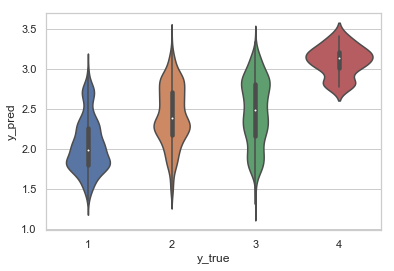

In [53]:
violin_plot_error(pipe2, X_test, y_test)

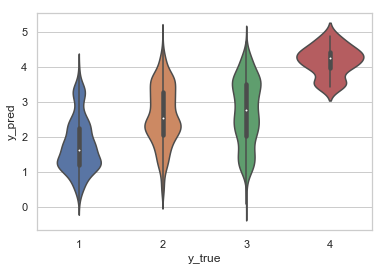

In [54]:
violin_plot_error(pipe2, X_test, y_test, rescale=True)


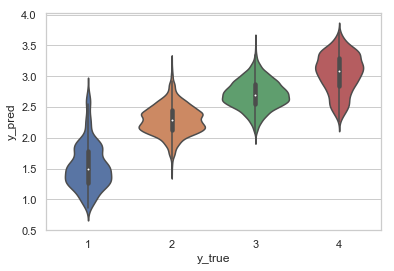

In [55]:
violin_plot_error(pipe2, X_train, y_train)

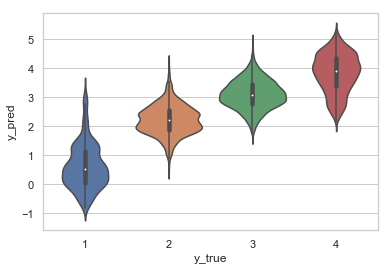

In [56]:
violin_plot_error(pipe2, X_train, y_train,rescale=True)

In [57]:
pipe2.steps

[('scaler', DataFrameMapper(default=False, df_out=False,
                  features=[(['Battery Voltage (v)', 'Temperature (deg F)',
                              'Wind Speed Minimum (mph)',
                              'Wind Speed Average (mph)',
                              'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
                              '24 Hour Snow (in)', 'Total Snow Depth (in)',
                              'max_1_day_temp', 'min_1_day_temp',
                              'max_2_day_temp', 'min_2_day_temp',
                              'max_1_day_snow', 'max_2_day_snow',
                              'max_3_day_snow'],
                             StandardScaler(copy=True, with_mean=True,
                                            with_std=True))],
                  input_df=False, sparse=False)),
 ('regressor',
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='ls', max_depth=3,


In [59]:
import pickle

In [60]:
# save the model to disk
filename = 'avy_danger_prediction.pkl'
pickle.dump(pipe2, open(filename, 'wb'))
 

In [61]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [65]:
X_test[1:2]

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_snow,max_2_day_snow,max_3_day_snow
12579,13.2,27.96,0.044,4.986,21.33,359.2,10.43,72.99,30.79,26.59,35.37,26.41,10.43,10.43,10.43


In [67]:
X_test.columns

Index(['Battery Voltage (v)', 'Temperature (deg F)',
       'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
       'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
       '24 Hour Snow (in)', 'Total Snow Depth (in)', 'max_1_day_temp',
       'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp', 'max_1_day_snow',
       'max_2_day_snow', 'max_3_day_snow'],
      dtype='object')

In [66]:
result = loaded_model.predict(X_test[1:2])
print(result)

[3.00455071]


In [ ]:
X_test.head()